In [1]:
import pandas as pd

In [123]:
reg_df = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';', dtype=np.int32)
auth_df = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';', dtype=np.int32)

## EDA

In [118]:
reg_df.shape

(1000000, 2)

In [120]:
auth_df.shape

(9601013, 2)

In [127]:
reg_df.isna().any()

reg_ts    False
uid       False
dtype: bool

In [128]:
auth_df.isna().any()

auth_ts    False
uid        False
dtype: bool

In [131]:
reg_df.duplicated().any()

False

In [133]:
auth_df.duplicated().any()

False

## Функция подсчета удержания пользователей по дням

Функция объединяет пользователей в когорты по признаку даты регистрации.

Размер когорты - 1 день

Можно задать даты начала и конца исследуемого окна

In [115]:
from datetime import datetime, timezone

def retention_rate(reg_df, auth_df, start_date, end_date):
    """
    reg_df: Dataframe - Датафрейм с данными о регистрициях пользователей
    auth_df: Dataframe - Датафрейм с данными о входах пользователей
    start_date: string - Дата начала наблюдаемого периода в формате YYYY-MM-DD
    end_date: string - Дата окончания наблюдаемого периода в формате YYYY-MM-DD
    """

    # Привожу строки дат в ограничители в формате timestamp (unix seconds)
    # К правому ограничителю добавляю 1 день, т.к. не известно в какой tz пользователь передает даты
    left_sentinel = datetime.strptime(start_date, "%Y-%m-%d").replace(tzinfo=timezone.utc).timestamp()
    right_sentinel = datetime.strptime(end_date, "%Y-%m-%d").replace(tzinfo=timezone.utc).timestamp() + 60*60*24

    # Фильтрую таблицы по сырым данным: т.к. это быстрее
    # Фильтрую по датам reg_ts и auth_ts, чтобы они входили в ограничители, что выше
    reg_df = reg_df.copy()
    reg_df = reg_df[(reg_df['reg_ts'] >= left_sentinel) & (reg_df['reg_ts'] <= right_sentinel)]
    reg_df['reg_ts'] = pd.to_datetime(reg_df['reg_ts'], unit='s')
    reg_df['reg_ts'] = pd.to_datetime(reg_df['reg_ts']).dt.date

    auth_df = auth_df.copy()
    auth_df = auth_df[(auth_df['auth_ts'] >= left_sentinel) & (auth_df['auth_ts'] <= right_sentinel)]
    auth_df['auth_ts'] = pd.to_datetime(auth_df['auth_ts'], unit='s')
    auth_df['auth_ts'] = pd.to_datetime(auth_df['auth_ts']).dt.date

    # Объединяю df
    union_df = reg_df.merge(auth_df, how = 'left', on = 'uid')
  
    # Группирую по дате reg_ts и auth_ts, чтобы посчитать количество уникальных пользователей
    union_data = union_df\
        .groupby(['reg_ts', 'auth_ts'], as_index = False)\
        .agg({'uid':'nunique'})\
        .rename(columns = {'uid': 'count'})

    # Разница между датой регистрации и датой входа
    union_data['delta_days'] = (union_data['auth_ts'] - union_data['reg_ts']).dt.days
    
    # Разбиваю данные на когорты по дате регистрации
    cohorts = union_data.pivot(index = 'reg_ts', columns = 'delta_days', values = 'count')

    # Возвращаю retation rate
    return cohorts.div(cohorts.iloc[:,0], axis = 0)

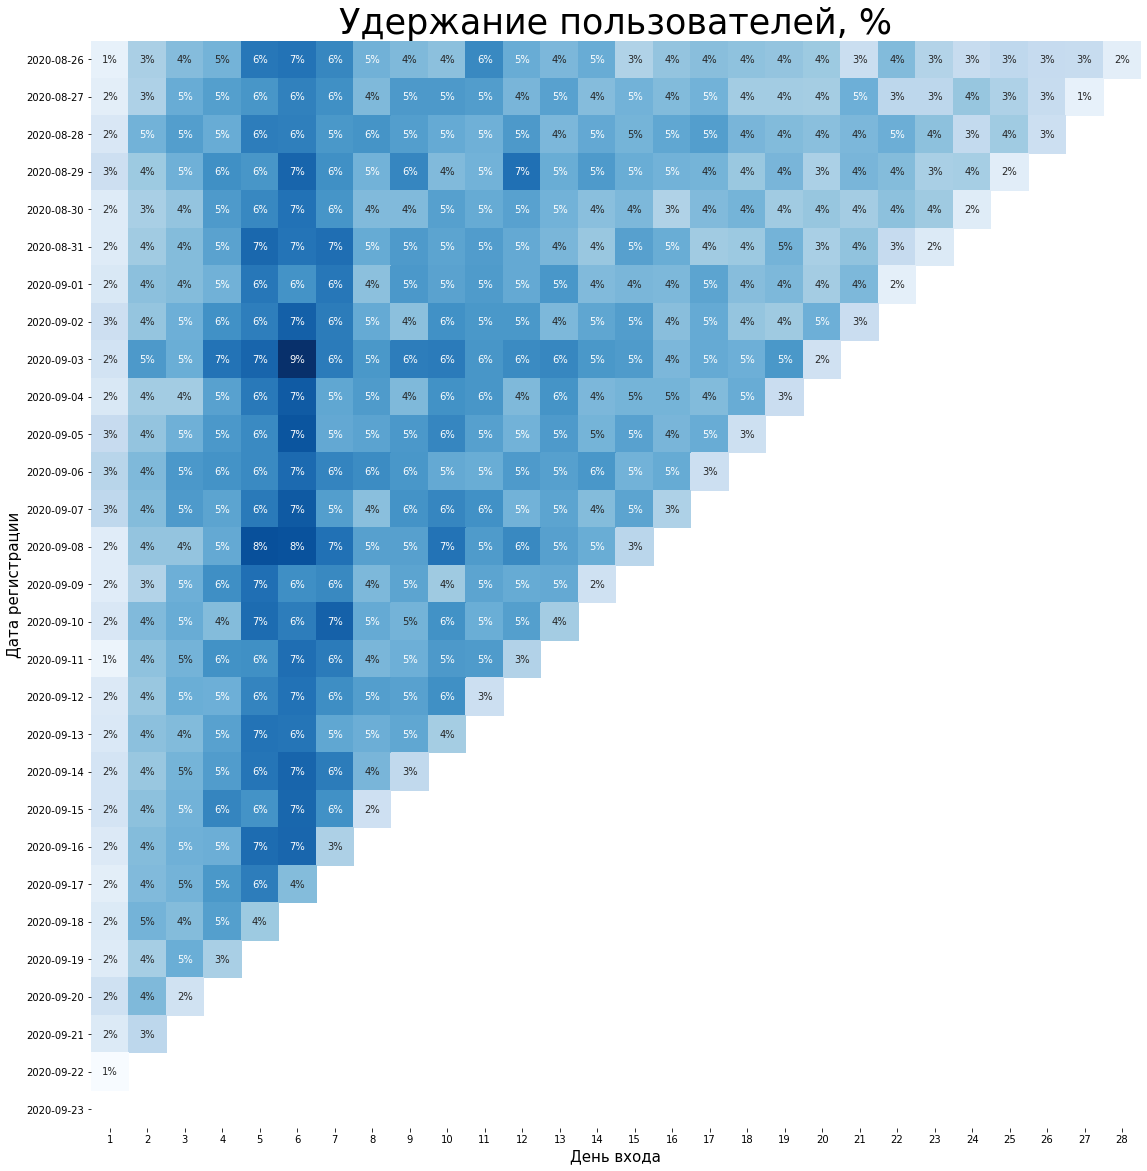

In [146]:
import seaborn as sns
from matplotlib import pyplot as plt

def plot_retention_rate(retention):
    retention = retention.copy()
    del retention[0]

    plt.figure(figsize=(20, 20))
    ax = sns.heatmap(
        data=retention,
        fmt='.0%',
        annot=True,
        square=True,
        cmap="Blues",
        cbar = False,
    )

    ax.set_title("Удержание пользователей, %", fontsize=35)
    ax.set_ylabel("Дата регистрации", fontsize=15)
    ax.set_xlabel("День входа", fontsize=15)

    plt.yticks(rotation=0)
    plt.show()

retention = retention_rate(reg_df, auth_df, '2020-08-26', '2020-09-23')
plot_retention_rate(retention)

## Вывод

Для оценки бизнеса я посмотрела, какой reatation rate в онлайн играх считается хорошим: ~10-13% на 7 день, ~5-7% на 28 день.

За исследуемый период с '2020-08-27' по '2020-09-23' ретеншн на 7 день ~6%, на 28 день 2%. Это меньше, пользовательский интерес к игре снижен. Но также видно, что ретеншн в первый день падает, а затем становится постоянным (выходит на плато). То, что падает быстро - может быть, что-то не так с первым впечатлением от приложения. Возможно, проблема с источником трафика, если его поменять и дать более адекватную рекламу, то показатель может повыситься. С другой стороны, если это очень дешевый трафик вроде 1 доллар за 1000 регистраций, и после него в игре остаются 4%, то это хороший результат. Также, если игра полностью платная, это могло бы быть неплохим результатом.
То, что наступает плато - хорошо, значит, пользователи становятся постоянными.


